# Gender in the Library of Congress Subject Headings

### Imports

In [1]:
import pickle as pk
import matplotlib.pyplot as plt 
import numpy as np
import latextable as lt
import texttable as tt
from tabulate import tabulate
import re
import csv
import collections
from Code import lcshFunctions as lcFunc
from Code import plottingFunctions as plots

In [2]:
'''
Calculate the percentage of the total covered by a subset 
'''
def percent(subset, total):
    return subset/total*100

## Preliminary Analysis

First I collect all terms with a LCSH and determine how many are simple terms (and how many of the simple terms are deprecated). 

In [3]:
with open('Data/LCSH/lcsh.pickle', 'rb') as f:
    lcsh = pk.load(f)

simpleLCSH = lcFunc.getSimpleTerms(lcsh)
simpleLCSH = lcFunc.pruneDeprecated(simpleLCSH) # remove those that were added and deprecated within a year
withParents = {idx:term for idx, term in simpleLCSH.items() if lcFunc.checkParents(term)}

outOfUse = [term for term in simpleLCSH.values() if term['heading'][0] == '_']
depIdx = [idx for idx, term in simpleLCSH.items() if term['heading'][0] == '_']

currentSimple = {idx:term for idx, term in simpleLCSH.items() if term['yearDep'] is None}

print(f'There are {len(lcsh):,} LCSHs:\n\t- {len(simpleLCSH):,} are simple terms\
      \n\t-- {percent(len(outOfUse), len(simpleLCSH)):.2f}% of those simple terms are deprecated\
      \n\t-- {percent(len(withParents), len(simpleLCSH)):.2f}% have parents')

There are 467,176 LCSHs:
	- 267,299 are simple terms      
	-- 1.07% of those simple terms are deprecated      
	-- 76.01% have parents


Then I read in lists of words used to identify women and words used to identify men. The reason the list for women is 2 words longer is because 'men' is sufficient to pick up terms about gay men but 'lesbian' is needed to pick up terms about gay women

In [4]:
words4women = lcFunc.readWordList('Data/terms4women.txt')
words4men = lcFunc.readWordList('Data/terms4men.txt')
print(f'There are {len(words4men)} words used to identify terms for men and {len(words4women)} for women.')

mTerms = lcFunc.getTermsWithWords(simpleLCSH, words4men, 'genTerm')
wTerms = lcFunc.getTermsWithWords(simpleLCSH, words4women, 'genTerm')
print(words4men, words4women)

There are 4 words used to identify terms for men and 4 for women.
['men', 'gentlemen', 'male', 'masculine'] ['women', 'ladies', 'female', 'feminine']


Next I remove all gendered terms that occur in both the set of terms for women and the set of terms for men. I also remove any term that mentions 'gay and lesbian' from the terms for women because they do not solely refer to women but my method still picks them up as such. 

In [5]:
inBoth = lcFunc.getAmbiguous(mTerms, wTerms)
phrases = ['gay and lesbian', 'lesbian and gay']
ambigPhrase = lcFunc.getTermsWithPhrase(wTerms, phrases)
print(f'There are {len(inBoth) + len(ambigPhrase)} terms that are ambiguous.')
print([lcsh[idx]['heading'] for idx in inBoth+ambigPhrase])

lcFunc.pruneAmbiguous(mTerms, wTerms, inBoth + ambigPhrase, 'heading', 'Data/LCSH/ambiguous-lcsh.txt')

with open('Data/LCSH/men-lcsh.txt', 'w') as f:
    for term in mTerms.values():
        f.write(f'{term['heading']}\n')

with open('Data/LCSH/women-lcsh.txt', 'w') as f:
    for term in wTerms.values():
        f.write(f'{term['heading']}\n')

There are 4 terms that are ambiguous.
['Male-to-female transsexuals', 'Women, Male (African people)', 'Female-to-male transsexuals in art', 'Female-to-male transsexuals']


Finally I report the number of terms for men and the number of terms for women, and report which terms are deprecated. There are about 5.5 more terms for women than men. The percentage of deprecated terms is pretty similar for both men and women and less than the overall percentage of deprecated simple terms. 

In [6]:
numDepM, deprecatedM = lcFunc.getDeprecated(mTerms)
print(f'There are {len(mTerms):,} terms for men. {numDepM:,} ({percent(numDepM, len(mTerms)):.2f}%) are deprecated.')
[term['heading'] for term in deprecatedM.values()]

There are 379 terms for men. 2 (0.53%) are deprecated.


['_African American HIV-positive men', '_Hispanic American HIV-positive men']

In [7]:
numDepW, deprecatedW = lcFunc.getDeprecated(wTerms)
print(f'There are {len(wTerms):,} terms for women. {numDepW:,} ({percent(numDepW, len(wTerms)):.2f}%) are deprecated.')
[term['heading'] for term in deprecatedW.values()]

There are 2,492 terms for women. 8 (0.32%) are deprecated.


['_Women illegal aliens',
 '_African American HIV-positive women',
 '_Indian HIV-positive women',
 "_Women's writings",
 '_Women, Surinamese',
 '_National Women and Girls in Sports Day',
 '_Women concentration camp guards',
 '_Women concentration camp inmates']

In [8]:
table1 = tt.Texttable()
table1.set_deco(tt.Texttable.HEADER)
table1.set_cols_align(['l'] + ['c']*3)
table1.set_cols_valign(['m']*4)
table1.add_rows([['~', '\\textbf{Men}', '\\textbf{Women}', '\\textbf{Total}'], 
                 ['\\textbf{In Use}', len(mTerms)-numDepM, len(wTerms)-numDepW, len(mTerms)+len(wTerms)-numDepM-numDepW], 
                 ['\\textbf{Deprecated}', numDepM, numDepW, numDepM+numDepW], 
                 ['\\textbf{Total}', len(mTerms), len(wTerms), len(mTerms)+len(wTerms)]])
table = lt.draw_latex(table1, caption='Number of gendered headings in the LCSH retrieved using the list of key words in \hyperref[tab:gendered-words]{Table 1}.', label='tab:term-counts', use_booktabs=True, caption_above=True)
                      
with open('Plots/table1.tex', 'w') as f:
    f.write(table)

<>:9: SyntaxWarning: invalid escape sequence '\h'
<>:9: SyntaxWarning: invalid escape sequence '\h'
C:\Users\kwarburton\AppData\Local\Temp\ipykernel_30488\1840240327.py:9: SyntaxWarning: invalid escape sequence '\h'
  table = lt.draw_latex(table1, caption='Number of gendered headings in the LCSH retrieved using the list of key words in \hyperref[tab:gendered-words]{Table 1}.', label='tab:term-counts', use_booktabs=True, caption_above=True)


In [9]:
ratio = (len(wTerms)-numDepW)/(len(mTerms)-numDepM)
print(f'There are {ratio:.2f} times as many terms for women as men.')

There are 6.59 times as many terms for women as men.


In [10]:
# save the gendered LCSH terms
with open('Data/LCSH/genderedLCSH.pickle', 'wb') as f:
    pk.dump((wTerms, mTerms), f, protocol=pk.HIGHEST_PROTOCOL)

## Diachronic Analysis

### Term counts

First I plot the cumulative numbers of terms for men and women over time. The reason the start date is 1986 even though the first edition of the LCSHs was introduced in 1910 is because that is when I believe the dataset was digitized. Thus 1986 is the first year in which any term could be added to this online database. 

The limitation is that any meaningful analysis of change over time is limited to changes that occur after 1986.

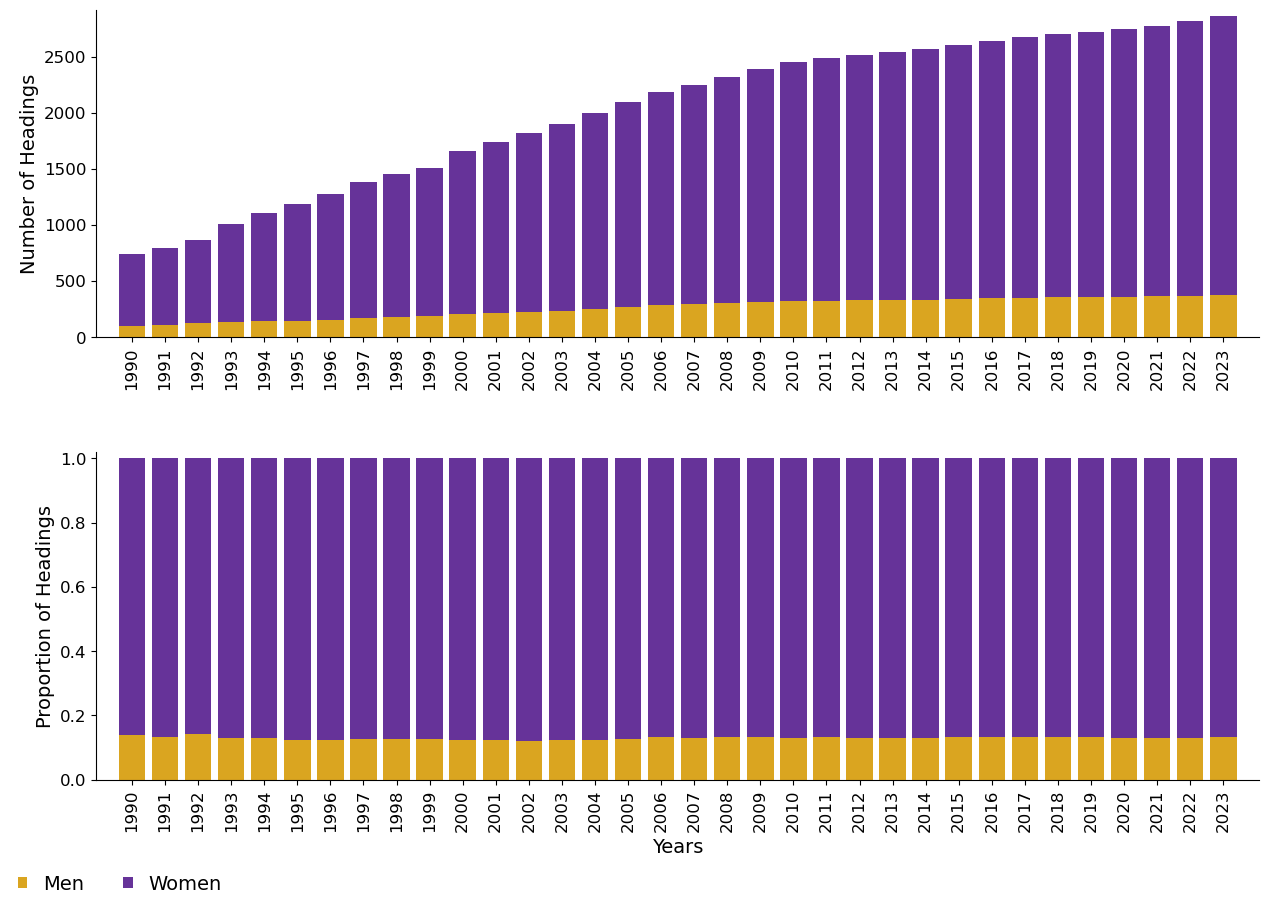

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax1, ax2 = axes

timelineW = lcFunc.getTimeline(wTerms)
timelineM = lcFunc.getTimeline(mTerms)

culmW = np.cumsum(list(timelineW.values()))
culmM = np.cumsum(list(timelineM.values()))
total = [culmW[i]+culmM[i] for i in range(len(culmM))]
yData = {
    "Men": culmM[4:],
    "Women": culmW[4:],
}
x = list(timelineM.keys())

plots.plotStacked(ax1, x[4:], yData, ['goldenrod', 'rebeccapurple'], yLabel='Number of Headings', legend=False)

propW = [culmW[i]/total[i] for i in range(len(culmW))]
propM = [culmM[i]/total[i] for i in range(len(culmM))]
yData = {
    "Men": propM[4:],
    "Women": propW[4:],
}
plots.plotStacked(ax2, x[4:], yData, ['goldenrod', 'rebeccapurple'], 'Years', 'Proportion of Headings')
fig.savefig('Plots/cumulativeTerms.png', dpi=500, bbox_inches='tight')

I then plot the relative proportion of terms for men versus terms for women over time. The proportion of terms stays pretty consistent over time. This suggests that each year terms for men and women were being added in equal rates (but not in equal numbers as that would change the proportion). 


Then I plot the number of terms added each year. I focus on terms added in 1990 to create a buffer around the time the dataset was first digitized. It appears there a drop off in the number of terms being added around 2011. I also report the average date of addition to the LCSHs.

Finally I look at what proportion of new gendered terms are for men and what proportion are for women over time. This plot is less flat, suggesting that the terms are not consistently added in the same proportion like previously predicted. There also doesn't appear to be any clear trend. 

2141
1866 275
0.2608695652173913 0.1275393284809186


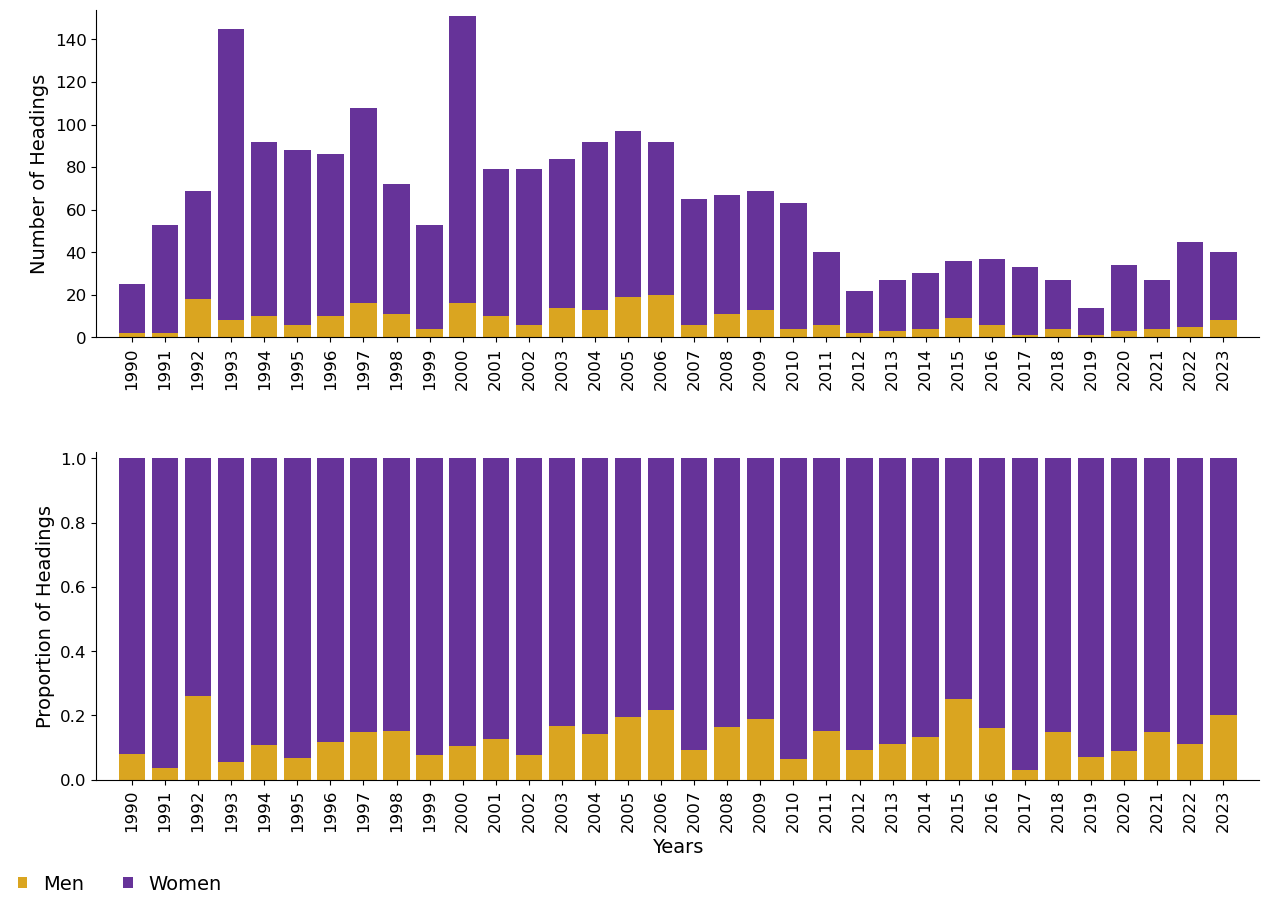

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax1, ax2 = axes

addedW = list(timelineW.values())[4:]
addedM = list(timelineM.values())[4:]
total = [addedW[i]+addedM[i] for i in range(len(addedM))]

print(sum(total))
print(sum(addedW), sum(addedM))

yData = {
    "Men": addedM,
    "Women": addedW,
}
x = list(timelineM.keys())

plots.plotStacked(ax1, x[4:], yData, ['goldenrod', 'rebeccapurple'], yLabel='Number of Headings', legend=False)


propW = [addedW[i]/total[i] for i in range(len(addedW))]
propM = [addedM[i]/total[i] for i in range(len(addedM))]
print(max(propM), np.mean(propM))

yData = {
    "Men": propM,
    "Women": propW,
}
plots.plotStacked(ax2, x[4:], yData, ['goldenrod', 'rebeccapurple'], 'Years', 'Proportion of Headings')
fig.savefig('Plots/addedTerms.png', dpi=500, bbox_inches='tight')

In [13]:
avgYearM = sum([year*count for year, count in timelineM.items() if year>=1990]) / sum(list(timelineM.values())[4:])
avgYearF = sum([year*count for year, count in timelineW.items() if year>=1990]) / sum(list(timelineW.values())[4:])
print(f'The average year of introduction of terms for men is {avgYearM:.0f} and {avgYearF:.0f} for women.')

The average year of introduction of terms for men is 2004 and 2003 for women.


### Term Frequency

I use [Google N-grams](https://books.google.com/ngrams/info) to approximate the frequency of LCSHs in books before their addition to the LCSH. Google Ngram contains word frequency data of n-grams found in Google Books between 1500 and 2022. The maximum n-gram size is 5. 

I focus on a subset of terms that were added between 1990 and 2020. The lower date bound is chosen so that it is easier to assume that the terms were added because they were new to the LCSH and not because they were in the process of being digitized. The upper date bound was chosen so there is a guarantee that, for every term, we have n-gram frequency for at least 2 years after its addition to the LCSH. 


In [14]:
mSubset = {idx:head for idx, head in mTerms.items() if lcFunc.yearAdded(head) >= 1990 and lcFunc.yearAdded(head) <=2020 and '_' not in head['heading']}
wSubset = {idx:head for idx, head in wTerms.items() if lcFunc.yearAdded(head) >= 1990 and lcFunc.yearAdded(head) <=2020 and '_' not in head['heading']}

mGrams, mYrs, mIdx = lcFunc.getNgrams(mSubset, 5, True)
wGrams, wYrs, wIdx = lcFunc.getNgrams(wSubset, 5, True)

ngramRate = len(wGrams)/len(mGrams)

with open('Data/Ngrams/mGrams.txt', 'w') as f:
    for i in range(len(mGrams)):
        f.write(f'{mIdx[i]}\t{mGrams[i]}\t{mYrs[i]}\n')

with open('Data/Ngrams/wGrams.txt', 'w') as f:
    for i in range(len(wGrams)):
        f.write(f'{wIdx[i]}\t{wGrams[i]}\t{wYrs[i]}\n')

print(f'There are {len(mGrams)} potential N-grams for men and {len(wGrams)} for women\nFor each potential term for men, there are {ngramRate:.1f} terms for women.')

There are 245 potential N-grams for men and 1710 for women
For each potential term for men, there are 7.0 terms for women.


I also collect a random subset of LCSHs to be used a comparison points in the frequency analysis. 

In [15]:
# nonOverlapping = {idx:term for idx, term in simpleLCSH.items() if (idx not in mTerms and idx not in wTerms 
#                                                                    and lcFunc.yearAdded(term) >= 1990 
#                                                                    and lcFunc.yearAdded(term) <=2020 
#                                                                    and '_' not in term['heading']
#                                                                    and term['type'] == 'Topic'
#                                                                    and term['lang'] == 'en')}
# randomSample = np.random.choice(list(nonOverlapping.keys()), len(wGrams)+len(mGrams)+800, replace=False)
# np.random.shuffle(randomSample)
# randomBaseline= {idx:simpleLCSH[idx] for idx in randomSample}
# rGrams, rYrs, rIdx = lcFunc.getNgrams(randomBaseline, 5)

# with open('Data/Ngrams/randomGrams-w-aligned.txt', 'w') as f:
#     for i in range(len(wGrams)):
#         f.write(f'{rIdx[i]}\t{rGrams[i]}\t{rYrs[i]}\n')

# with open('Data/Ngrams/randomGrams-m-aligned.txt', 'w') as f:
#     for i in range(len(wGrams), len(wGrams)+len(mGrams)):
#         f.write(f'{rIdx[i]}\t{rGrams[i]}\t{rYrs[i]}\n')


with open('Data/Ngrams/randomGrams-w-aligned.txt', 'r') as f:
    rGramsW = [line.split('\t')[1] for line in f.readlines()]

with open('Data/Ngrams/randomGrams-m-aligned.txt', 'r') as f:
    rGramsM = [line.split('\t')[1] for line in f.readlines()]



Of the potential n-grams, only a subset are included in Google N-gram. This subset percentage is relatively consistent between terms for men and women. 

In [16]:
mFreqs, mYrs, mHeads, mIndices = lcFunc.getNgramData('Data/Ngrams/mGrams.csv')
wFreqs, wYrs, wHeads, wIndices = lcFunc.getNgramData('Data/Ngrams/wGrams.csv')
rFreqsM, rYrsM, rHeadsM, rIndicesM = lcFunc.getNgramData('Data/Ngrams/rGramsM.csv')
rFreqsW, rYrsW, rHeadsW, rIndicesW = lcFunc.getNgramData('Data/Ngrams/rGramsW.csv')


ngramRate = len(wHeads)/len(mHeads)

percent(len(wHeads), len(wGrams))

mSize = np.mean([len(head.split(' ')) for head in mHeads])
wSize = np.mean([len(head.split(' ')) for head in wHeads])
# rSize = np.mean([len(head.split(' ')) for head in rHeads])

print(len(mHeads), len(wHeads))

print(f'{percent(len(mHeads), len(mGrams)):.2f}% of the potential ngrams for men were actually in google N-gram, {percent(len(wHeads), len(wGrams)):.2f}% for women.')
print(f'For each actual n-gram for men, there are {ngramRate:.1f} n-grams for women.')
print(f'There average n-gram size for terms about women is {wSize:.2f}, {mSize:.2f} for terms about men.')
print(f'The average year of addition for the terms with n-grams is {np.mean(wYrs):.0f} for women, {np.mean(mYrs):.0f} for men.')


151 949
61.63% of the potential ngrams for men were actually in google N-gram, 55.50% for women.
For each actual n-gram for men, there are 6.3 n-grams for women.
There average n-gram size for terms about women is 2.70, 2.78 for terms about men.
The average year of addition for the terms with n-grams is 2000 for women, 2003 for men.


I plot the yearly median n-gram frequency of terms for men and terms for women for the 10 years proceeding the addition of a term to the LCSHs and for the 2 years after its addition. I use the median because initial  exploration of the n-gram frequency suggested that it is left skewed (towards low frequencies). In this graph its clear that the terms for men are, on average, more frequent than the terms for women. This is the opposite of what I expected, given that women are often the marked case in language (My assumption was that we don't always specify when someone is a man, but will specify when they are a woman.)

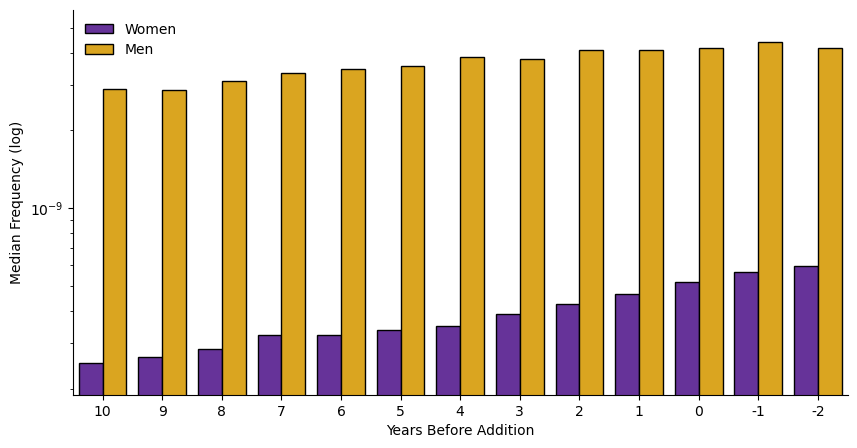

In [17]:
mRawFreqs = plots.getRawFreqs(mFreqs, mYrs, 10, 2)
wRawFreqs = plots.getRawFreqs(wFreqs, wYrs, 10, 2)
wFreqAvg = np.median(wRawFreqs, axis=0)
mFreqAvg = np.median(mRawFreqs, axis=0)

plots.plotSideBySide(wFreqAvg, mFreqAvg, log=True)
plt.savefig('Plots/medianFreqsBeside.png', dpi=500, bbox_inches='tight')


In [18]:
print(mFreqAvg, wFreqAvg)

[2.89056598e-09 2.85832241e-09 3.10264511e-09 3.33902919e-09
 3.46437222e-09 3.54328099e-09 3.83634674e-09 3.77336021e-09
 4.09170537e-09 4.09833741e-09 4.16799195e-09 4.40260867e-09
 4.18094249e-09] [2.52204797e-10 2.65274518e-10 2.84551701e-10 3.23301793e-10
 3.23767718e-10 3.38200742e-10 3.50701894e-10 3.90602903e-10
 4.26046790e-10 4.64841841e-10 5.19145897e-10 5.67806875e-10
 5.98840943e-10]


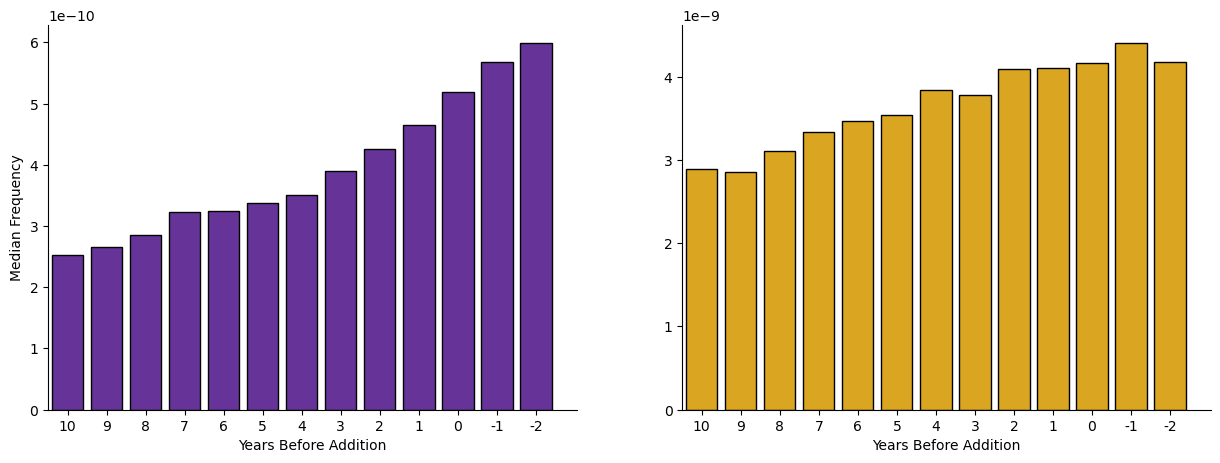

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax1, ax2 = axes
plots.barPlots(ax1, wFreqAvg, 10, 2, colour='rebeccapurple', ylabel=True)
plots.barPlots(ax2, mFreqAvg, 10, 2, colour='goldenrod')
plt.savefig('Plots/medianFreqs.png', dpi=500, bbox_inches='tight')


Instead of looking at average frequency, I then look at the average proportion of frequency over the same 13 year span (10 years before a term was added and 2 years after). The proportion of frequency is calculated by dividing each years frequency count by the total frequency of the n-gram in the 13 year span. I then take the mean of all frequency proportions for each year. 

There is a clear elbow for women terms 2 years before a term is added to the LCSHs. This means that there is a spike in the proportion of frequency one year before a term is added. The same elbow does not appear in the line representing the terms for men or the random set of terms. In fact, there is no clear elbow at any point in either of their plots. 

Although their is a definite difference in the shape of the line representing the terms for women, I'm cautious about drawing too many conclusions because its on a pretty small scale. 

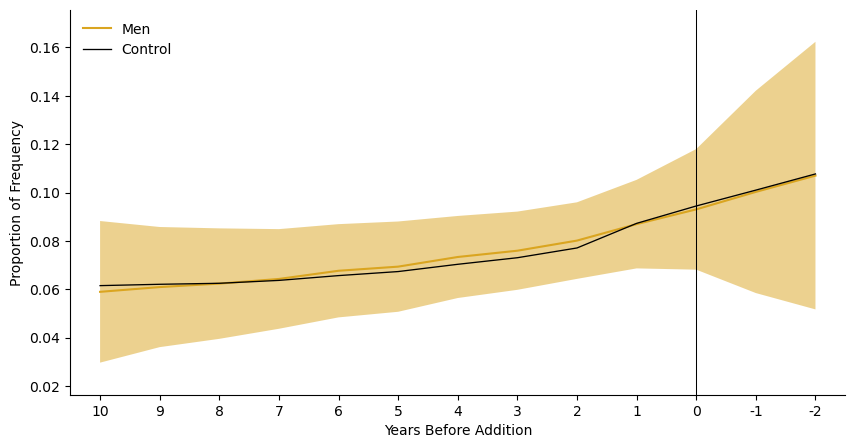

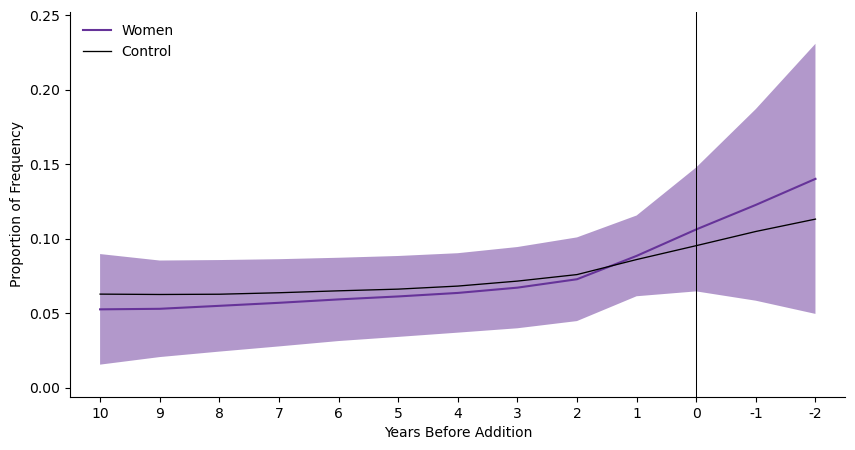

In [20]:
mAvg, mStd = plots.getAvgProp(mFreqs, mYrs, 10, 2)
#mControl = plots.getControl(mFreqs, 10, 2)

rFreqsM, rYrsM = rFreqsW[:len(mYrs)], rYrsW[:len(mYrs)]

rAvgM, rStdM = plots.getAvgProp(rFreqsM, rYrsM, 10, 2)

wAvg, wStd = plots.getAvgProp(wFreqs, wYrs, 10, 2)
#wControl = plots.getControl(wFreqs, 10, 2)
rFreqsW, rYrsW = rFreqsW[:len(wYrs)], rYrsW[:len(wYrs)]
rAvgW, rStdW = plots.getAvgProp(rFreqsW, rYrsW, 10, 2)


plots.plotAvgFreq(mAvg, mStd, 'Men', len(mYrs), color='goldenrod', control=rAvgM)
plots.plotAvgFreq(wAvg, wStd, 'Women', len(wYrs), color='rebeccapurple', control=rAvgW)



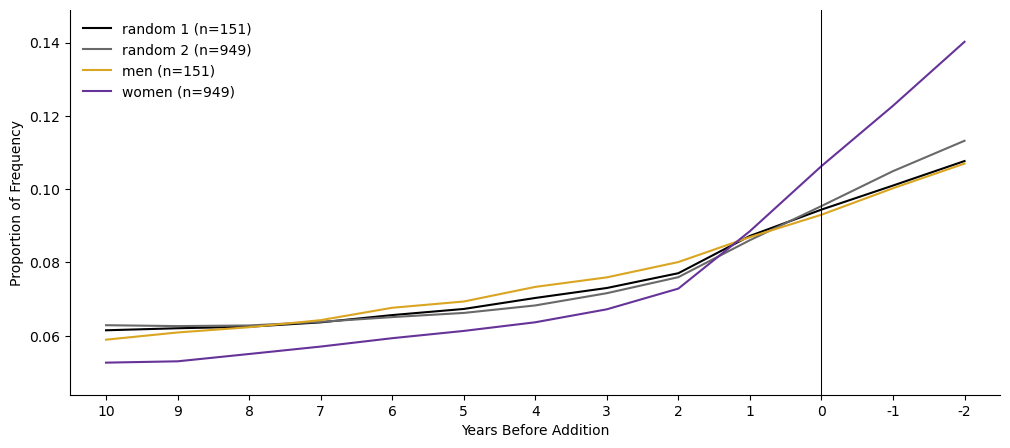

In [21]:
plots.plotMultipleFreqs([rAvgM, rAvgW, mAvg, wAvg], ['random 1', 'random 2', 'men', 'women'], [len(rYrsM), len(rYrsW), len(mYrs), len(wYrs)], [ 'black', 'dimgrey', 'goldenrod', 'rebeccapurple'])
plt.savefig('Plots/avgFreqs.png', dpi=500, bbox_inches='tight')

## Markedness Analysis
This analysis focuses on how balanced the gendered LCSHs are. For example, if there is a LCSH for 'Women in Science' than does a corresponding LCSH for 'Men in Science' exist? Because there are substantially more terms for women than men, we can assume that there will be more terms for women without a corresponding term for men than vice versa, however the extent to which this is the case is still interesting. As well, some analysis of which terms for men and women are unpaired could provide insight into more content-based/sentiment-based biases. 


### Just looking at the pairs. 
First I focus on the terms that are the exact same, except for the inclusion of a set of matched gendered word. Some example of potential pairs include 'Sports for girls'-'Sports for boys', 'Wives'-'Husbands', 'Male artists'-'Women artists', etc. For a full list of matched gendered words see *pairedTerms.txt*. 

*Note: The reason 'Male' and 'Women' are matched is because the Library of Congress seems to have an aversion to using 'Female' as an adjective and only uses it in certain scenarios (i.e. 'Female offenders'). Instead they use 'Women' as an adjective. The same aversion to 'Male' does not exist and thus 'Men' is never used as an adjective.* 

In [22]:
pairs = []
with open('Data/pairedTerms.txt', 'r') as f:
    for line in f:
        pair = line.replace('\n', '').split('\t')
        pairs.append(pair)

pairedTerms = lcFunc.findPairs(mTerms, wTerms, pairs)

with open('Data/LCSH/pairs-lcsh.txt', 'w') as f:
    for mTerm, wTerm in pairedTerms:
        f.write(f'{mTerm[1]['heading']}\t{wTerm[1]['heading']}\n')

print(f'There are {len(pairedTerms)} paired terms in the LCSH.')
print(f'{percent(len(pairedTerms), len(mTerms)-numDepM):.2f}% of terms for men (or of the max number of potential paired terms) and {percent(len(pairedTerms), len(wTerms)-numDepW):.2f}% of terms for women are paired.')
print(f'There are {len(mTerms) - len(pairedTerms)} terms for men that are unpaired and {len(wTerms) - len(pairedTerms)} terms for women.')

There are 197 paired terms in the LCSH.
52.25% of terms for men (or of the max number of potential paired terms) and 7.93% of terms for women are paired.
There are 182 terms for men that are unpaired and 2295 terms for women.


Of the paired terms, the terms for women tend to be added before their corresponding term for men. For this comparison I focus on pairs where at least one term was added in 1990 or later. This fits with library science literature that suggests that terms for men were added in an attempt to balance the imbalance between terms for women and men. 

As well, the average date of addition is more recent for men than it is for women. For calculating the average date of addition I only look at terms were both in the pair were added after 1990.

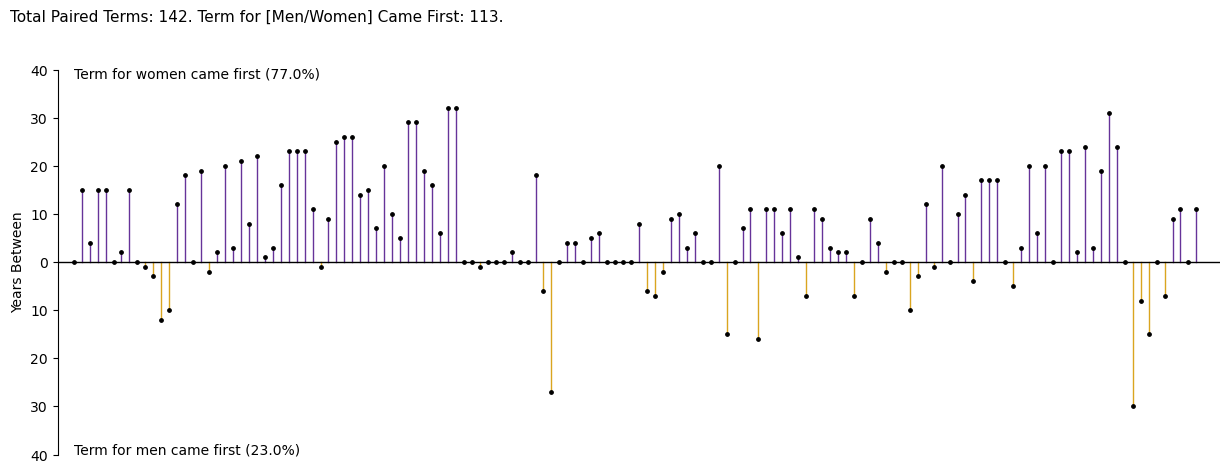

The average year of introduction for men in the paired terms is 2004 and 2002 for women.
There is an average difference of 2.02 years between the introduction of paired terms.


In [23]:
mYearAdded = np.mean([lcFunc.yearAdded(m[1]) for m,w in pairedTerms if lcFunc.yearAdded(m[1]) >= 1990 and lcFunc.yearAdded(w[1]) >= 1990])
wYearAdded = np.mean([lcFunc.yearAdded(w[1]) for m,w in pairedTerms if lcFunc.yearAdded(w[1]) >= 1990 and lcFunc.yearAdded(m[1]) >= 1990])
y = [lcFunc.yearAdded(m[1]) - lcFunc.yearAdded(w[1]) for m,w in pairedTerms if lcFunc.yearAdded(m[1]) >= 1990 or lcFunc.yearAdded(w[1]) >= 1990]
x = [i for i in range(len(y))]
plots.whoCameFirst(x, y)

print(f'The average year of introduction for men in the paired terms is {mYearAdded:.0f} and {wYearAdded:.0f} for women.')
print(f'There is an average difference of {mYearAdded - wYearAdded:.2f} years between the introduction of paired terms.')

### Looking at the Parents as well. 
[Falenska, A. & Cetinoglu, O. (2021).](https://aclanthology.org/2021.gebnlp-1.9/) perform a similar markedness analysis on Wikipedia pages. However, they also look at the 'generic' parents of these terms. For example, if a gendered term like 'Women Scientists' exists does a generic parent term such as 'Scientists' exist? If the generic term exists does the corresponding term for men also exist? If it doesn't, this illuminates specific cases where men are assumed to be the default (and vice versa when the imbalance skews towards women).

The LCSHs actually store the parent terms of its subject headings (called broader terms). A LCSH can have multiple parents and the percentage of terms with parents, as well as the mean number of parents per term is reported. 

In [24]:
mTermsCurr = {idx:term for idx, term in mTerms.items() if term['yearDep'] is None}
wTermsCurr = {idx:term for idx, term in wTerms.items() if term['yearDep'] is None}
pairedTermsCurr = [(m,w) for m,w in pairedTerms if m[0] in mTermsCurr and w[0] in wTermsCurr]
print(len(mTermsCurr), len(wTermsCurr))

print(len(pairedTermsCurr))

377 2484
196


In [25]:
mWithParents = {idx:term for idx, term in mTermsCurr.items() if lcFunc.checkParents(term)}
wWithParents = {idx:term for idx, term in wTermsCurr.items() if lcFunc.checkParents(term)}

mAvgNumParents = np.mean([len(lcFunc.getParents(term, lcsh)) for term in mWithParents.values()])
wAvgNumParents = np.mean([len(lcFunc.getParents(term, lcsh)) for term in wWithParents.values()])
mMaxParents = max([len(lcFunc.getParents(term, lcsh)) for term in mWithParents.values()])
wMaxParents = max([len(lcFunc.getParents(term, lcsh)) for term in wWithParents.values()])
print(f'{len(mWithParents)} ({percent(len(mWithParents), len(mTermsCurr)):.2f}%) terms for men have parents and {len(wWithParents)} ({percent(len(wWithParents), len(wTermsCurr)):.2f}%) terms for women.')
print(f'Of the terms with parents, terms for women have on average {wAvgNumParents:.2f} parents and terms for men {mAvgNumParents:.2f}.')
print(f'The maximum number of parents for terms is {mMaxParents:.2f} for men and {wMaxParents:.2f} for women.')

302 (80.11%) terms for men have parents and 1815 (73.07%) terms for women.
Of the terms with parents, terms for women have on average 1.40 parents and terms for men 1.24.
The maximum number of parents for terms is 4.00 for men and 5.00 for women.


The LCSH parents are not always the 'generic' parent term in the same way that they are in the Wikipedia analysis, especially given a term can have multiple parents. In many cases, the parents are more general gendered terms. For example, 'Women scientists' can have the parent 'Scientists' and the parent 'Women'. 

In [26]:
mHasGendered, mOnlyGendered = lcFunc.countGenderedParents(mTermsCurr, lcsh)
wHasGendered, wOnlyGendered = lcFunc.countGenderedParents(wTermsCurr, lcsh)
print(f'{mHasGendered} ({percent(mHasGendered, len(mWithParents)):.2f}%) of terms for men with parents have gendered parents and {wHasGendered} ({percent(wHasGendered, len(wWithParents)):.2f}%) of terms for women.')
print(f'Of these terms, {mOnlyGendered} ({percent(mOnlyGendered, mHasGendered):.2f}%) of terms for men only have a gendered parent and {wOnlyGendered} ({percent(wOnlyGendered, wHasGendered):.2f}%) of terms for women.')
print(f'Thus there are {len(mWithParents) - mOnlyGendered} terms for men that could have a generic parent and {len(wWithParents) - wOnlyGendered} terms for women.')

148 (49.01%) of terms for men with parents have gendered parents and 1183 (65.18%) of terms for women.
Of these terms, 99 (66.89%) of terms for men only have a gendered parent and 600 (50.72%) of terms for women.
Thus there are 203 terms for men that could have a generic parent and 1215 terms for women.


Determining the 'generic' parent of LCSHs is not necessarily trivial. It could be something as simple as 'Women Scientists' and 'Scientists', however there are also cases where words must be substituted to find the 'generic' parent. For example 'People in the film industry' and 'Men in the film industry' or 'Sons', 'Daughters' and 'Children'.

In [27]:
cleanedLcsh = lcFunc.cleanLCSH(currentSimple)
subSet = {idx:words for idx, words in cleanedLcsh.items() if 'woman' not in words 
          and 'lady' not in words 
          and 'feminine' not in words 
          and 'female' not in words
          and 'male' not in words
          and 'gentleman' not in words
          and 'man' not in words
          and 'masculine' not in words
          }

In [28]:
mHasGeneric = 0
mg, mgParents = [], []
for term in mWithParents.values():
    parents = lcFunc.getParents(term, lcsh)
    genParent = lcFunc.getGenericParent(term, parents)
    if genParent != []:
        mHasGeneric += 1
        mg.append(term['heading'])
        mgParents.append(genParent[0]['heading'])
    if len(genParent) > 1:
        print('weird')


wHasGeneric = 0
wg, wgParents = [], []
for term in wWithParents.values():
    parents = lcFunc.getParents(term, lcsh)
    genParent = lcFunc.getGenericParent(term, parents)
    if genParent != []:
        wHasGeneric += 1
        wg.append((term['heading']))
        wgParents.append(genParent[0]['heading'])
    if len(genParent) > 1:
        print('weird')

pHasGeneric, pNoGeneric = 0, 0
wmg, wm = [], []
wmgParents = []
for m, w in pairedTermsCurr:
    parentsM = lcFunc.getParents(m[1], lcsh)
    genParentM = lcFunc.getGenericParent(m[1], parentsM)
    parentsW = lcFunc.getParents(w[1], lcsh)
    genParentW = lcFunc.getGenericParent(w[1], parentsW)
    if m[1]['heading'] in mg:
        mHasGeneric -= 1
        mg.remove(m[1]['heading'])
        mgParents.remove(genParentM[0]['heading'])
    if w[1]['heading'] in wg:
        wHasGeneric -= 1
        wg.remove(w[1]['heading'])
        wgParents.remove(genParentW[0]['heading'])
    if genParentM != [] and genParentW != []:
        pHasGeneric += 1
        wmg.append((m[1]['heading'], w[1]['heading']))
        wmgParents.append((genParentM[0]['heading']))
    elif lcFunc.getGeneric(m[1], subSet) != '' and lcFunc.getGeneric(w[1], subSet) != '':
        pHasGeneric += 1
        wmg.append((m[1]['heading'], w[1]['heading']))
        wmgParents.append(lcsh[(lcFunc.getGeneric(m[1], subSet))]['heading'])
    else:
        pNoGeneric += 1
        wm.append((m[1]['heading'], w[1]['heading']))
    if len(genParent) > 1:
        print('weird')

wCases = wg + [w for _, w in wmg] + [w for _, w in wm]
mCases = mg + [m for m, _ in wmg] + [m for m, _ in wm]
justW = [term for term in wTermsCurr.values() if term['heading'] not in wCases]
justM= [term for term in mTermsCurr.values() if term['heading'] not in mCases]

w = []
for term in justW:
    generic = lcFunc.getGeneric(term, subSet)
    if generic != '':
        wg.append(term['heading'])
        wgParents.append(lcsh[generic]['heading'])
        wHasGeneric += 1
    else:
        w.append(term['heading'])

m = []
for term in justM:
    generic = lcFunc.getGeneric(term, subSet)
    if generic != '':
        mg.append(term['heading'])
        mgParents.append(lcsh[generic]['heading'])
        mHasGeneric += 1
    else:
        m.append(term['heading'])

Table

In [29]:
table2 = tt.Texttable()
table2.set_deco(tt.Texttable.HEADER)
table2.set_cols_align(['r', 'l'])
table2.add_rows([['\\textbf{Cases}', '\\textbf{Counts}'],
                 ['W {\\textbar} M {\\textbar} G', pHasGeneric],
                 ['W {\\textbar} M', pNoGeneric],
                 ['W {\\textbar} G', wHasGeneric],
                 ['M {\\textbar} G', mHasGeneric],
                 ['W', len(wTermsCurr) - pHasGeneric - pNoGeneric - wHasGeneric],
                 ['M', len(mTermsCurr) - pHasGeneric - pNoGeneric - mHasGeneric]])
table = lt.draw_latex(table2, caption='Marked cases and their frequencies in the LCSH.', label='tab:markedness', use_booktabs=True, caption_above=True)
                      
with open('Plots/table2.tex', 'w') as f:
    f.write(table)

In [30]:
print(len(mg), len(wg), len(wmg), len(wm))
print(len(w), len(m))

with open('Data/LCSH/justW.txt', 'w') as f:
    for head in w:
        f.write(f'{head}\n')

with open('Data/LCSH/justM.txt', 'w') as f:
    for head in m:
        f.write(f'{head}\n')

with open('Data/LCSH/WM-WMG.txt', 'w') as f:
    f.write('W | M | G\n--------------------------------\n')
    for i in range(len(wmg)):
        f.write(f'{wmg[i][0]}\t{wmg[i][1]}\t{wmgParents[i]}\n')
    f.write('\n\nW | M\n--------------------------------\n')
    for head in wm:
        f.write(f'{head[0]}\t{head[1]}\n')

with open('Data/LCSH/WG.txt', 'w') as f:
    for i in range(len(wg)):
        f.write(f'{wg[i]}\t{wgParents[i]}\n')

with open('Data/LCSH/MG.txt', 'w') as f:
    for i in range(len(mg)):
        f.write(f'{mg[i]}\t{mgParents[i]}\n')
    

93 1569 134 62
719 88
